In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tour-travels-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1684892%2F2761329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T173645Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D37d86e500701792e9af6059b18903ba5e0f67a764c2e203f38784df13dfc93b34ae07acfdcc4ad5e9f8b3099e2cb4046c4cd7fb815c21e9fef1ae6afc38d6fb0373133c882ff4165d67444e39434cc07a3a79724b39d3dc1876b269ea7562c8f31ac6479865e3e81660a5fa6e979515e8e674773531a372de54095bd5aa616aa186c07275c7db2ae5fae1665b98822e5c7e724fe677c459b02f361a37d5aab8af18ab0e848b2656739b3057231f28d3d187dcd377957459b1312b9d3d9311ad16681e1a34a937c226cfc4481167976db79dc4012ae04a284410c209df3b8c7a976a8eb5e38dcf59caa5ca65f4d978dbb4dd92f2926041634c1114fc2e62efc66'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3537 bytes downloaded
Downloaded and uncompressed: tour-travels-customer-churn-prediction
Data source import complete.


# Predicting & Reducing Customer Churn using Advance Data Analytics Techniques
This notebook aims to address the issue of customer churn by leveraging advanced data analytics and machine learning techniques. The primary objectives of this analysis are:

1. Predicting Customer Churn: Develop a predictive model to identify customers who are likely to churn. By accurately predicting churn, businesses can proactively engage at-risk customers with targeted retention strategies.
2. Customer Segmentation: Segment customers based on their behaviors and characteristics using clustering techniques. Segmentation helps in understanding different customer groups and tailoring marketing strategies to meet their specific needs.

## 1. Install necessary libraries

In [4]:
!pip install shap imblearn tpot
!pip install tpot
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tpot import TPOTClassifier
import shap


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.4 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=cc27a033eb98d2a4335f9f1631d932bab1838fb06e3a036a5a0cab8034045e99
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


## 2. Load the new dataset

In [5]:
file_path = '/kaggle/input/tour-travels-customer-churn-prediction/Customertravel.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

   Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0  


# 3. Check for missing values

In [9]:
print(df.isnull().sum())

# Step 1.1: Handle missing values for numeric columns only
df.fillna(df.mean(numeric_only=True), inplace=True)

# Check for missing values after filling
print(df.isnull().sum())

Age                           0
FrequentFlyer                 0
AnnualIncomeClass             0
ServicesOpted                 0
AccountSyncedToSocialMedia    0
BookedHotelOrNot              0
Target                        0
dtype: int64
Age                           0
FrequentFlyer                 0
AnnualIncomeClass             0
ServicesOpted                 0
AccountSyncedToSocialMedia    0
BookedHotelOrNot              0
Target                        0
dtype: int64


## 4. Encode categorical variables

In [12]:
label_encoder = LabelEncoder()
categorical_cols = ['FrequentFlyer', 'AnnualIncomeClass', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])


## 4. Feature scaling

        Age  FrequentFlyer  AnnualIncomeClass  ServicesOpted  \
0  0.566904              0                  2       2.219330   
1  0.566904              2                  1       1.596429   
2  1.466282              0                  2       0.350627   
3 -0.632267              0                  2      -0.272274   
4 -0.632267              0                  1      -0.895175   

   AccountSyncedToSocialMedia  BookedHotelOrNot  Target  
0                           0                 1       0  
1                           1                 0       1  
2                           1                 0       0  
3                           0                 0       0  
4                           0                 0       0  


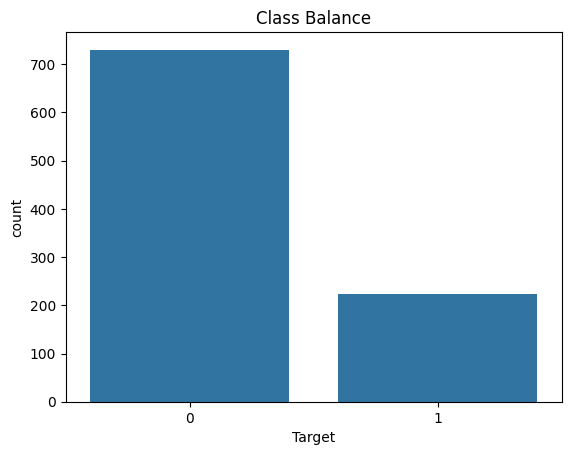

Target
0    730
1    224
Name: count, dtype: int64


In [13]:

scaler = StandardScaler()
df[['Age', 'ServicesOpted']] = scaler.fit_transform(df[['Age', 'ServicesOpted']])

# Display the preprocessed dataset
print(df.head())

# Check the balance of the target variable
sns.countplot(x='Target', data=df)
plt.title('Class Balance')
plt.show()

# Display the count of each class
print(df['Target'].value_counts())

# Split the data into features and target
X = df.drop('Target', axis=1)
y = df['Target']

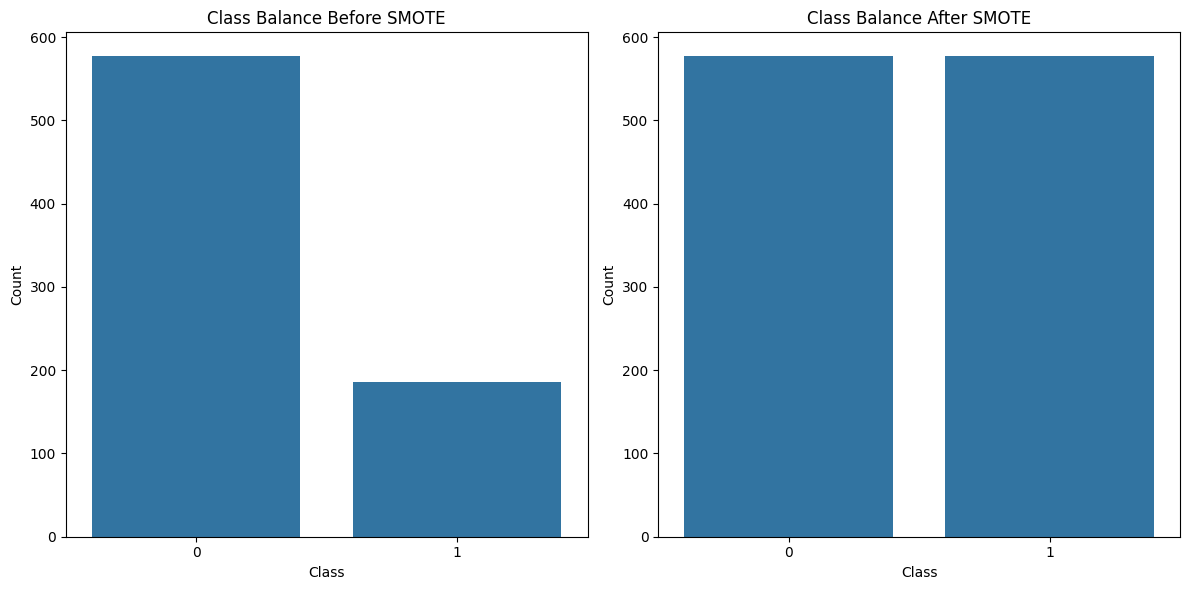

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the new dataset
file_path = '/kaggle/input/tour-travels-customer-churn-prediction/Customertravel.csv'  # Update this path as needed
df = pd.read_csv(file_path)

# Handle missing values for numeric columns only
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['FrequentFlyer', 'AnnualIncomeClass', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Feature scaling
scaler = StandardScaler()
df[['Age', 'ServicesOpted']] = scaler.fit_transform(df[['Age', 'ServicesOpted']])

# Split the data into features and target
X = df.drop('Target', axis=1)
y = df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Plot class balance before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Before SMOTE
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Class Balance Before SMOTE')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# After SMOTE
sns.countplot(x=y_res, ax=ax[1])
ax[1].set_title('Class Balance After SMOTE')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


## 5. Split the data into training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Check the new balance
print(pd.Series(y_res).value_counts())


Target
0    577
1    577
Name: count, dtype: int64


## 6. Implement TPOT for AutoML

In [16]:
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, n_jobs=-1)
tpot.fit(X_res, y_res)

# Evaluate the best model found by TPOT
y_pred = tpot.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'TPOT Model - Accuracy: {accuracy:.2f}')
print(f'TPOT Model - Precision: {precision:.2f}')
print(f'TPOT Model - Recall: {recall:.2f}')
print(f'TPOT Model - F1 Score: {f1:.2f}')

# Extract and manually retrain the best pipeline found by TPOT
best_pipeline = tpot.fitted_pipeline_
best_pipeline.fit(X_res, y_res)

# Evaluate the best pipeline
y_pred_best = best_pipeline.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f'Best Pipeline - Accuracy: {accuracy_best:.2f}')
print(f'Best Pipeline - Precision: {precision_best:.2f}')
print(f'Best Pipeline - Recall: {recall_best:.2f}')
print(f'Best Pipeline - F1 Score: {f1_best:.2f}')

# Explain the best pipeline's predictions using SHAP
# Since we have a complex pipeline, we'll explain each step separately if needed

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9151025785808395

Generation 2 - Current best internal CV score: 0.9159796725014117

Generation 3 - Current best internal CV score: 0.9194315829098437

Generation 4 - Current best internal CV score: 0.9194391116130246

Generation 5 - Current best internal CV score: 0.9194391116130246

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=10, min_child_weight=5, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
TPOT Model - Accuracy: 0.88
TPOT Model - Precision: 0.67
TPOT Model - Recall: 0.82
TPOT Model - F1 Score: 0.74
Best Pipeline - Accuracy: 0.88
Best Pipeline - Precision: 0.67
Best Pipeline - Recall: 0.82
Best Pipeline - F1 Score: 0.74


In [17]:
# Make predictions using the best pipeline
y_pred_best = best_pipeline.predict(X_test)

# Calculate the predicted churn rate
predicted_churn_rate = np.mean(y_pred_best) * 100  # Convert to percentage

# Print the predicted churn rate
print(f"Predicted Churn Rate: {predicted_churn_rate:.2f}%")


Predicted Churn Rate: 24.08%


# Customer Segmentation

## Step 1: Data Preprocessing

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the new dataset
file_path = '/kaggle/input/tour-travels-customer-churn-prediction/Customertravel.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Handle missing values for numeric columns only
df.fillna(df.mean(numeric_only=True), inplace=True)

# Check for missing values after filling
print(df.isnull().sum())

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['FrequentFlyer', 'AnnualIncomeClass', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Feature scaling
scaler = StandardScaler()
df[['Age', 'ServicesOpted']] = scaler.fit_transform(df[['Age', 'ServicesOpted']])

# Display the preprocessed dataset
print(df.head())


   Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0  
Age                           0
FrequentFlyer                 0
AnnualIncomeClass             0
ServicesOpted                 0
AccountSyncedToSocialMedia    0
BookedHotelOrNot              0
Target                        0
dtype: int64
Age                           0
FrequentFlyer                 0
AnnualIncomeClass   

 ## Step 2. Apply K-means Clustering for Customer Segmentation

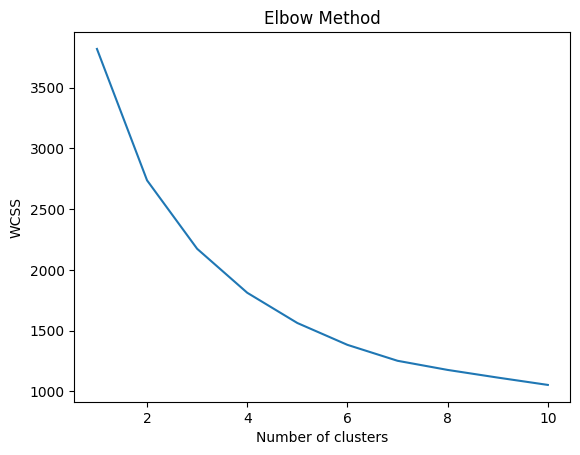

        Age  FrequentFlyer  AnnualIncomeClass  ServicesOpted  \
0  0.566904              0                  2       2.219330   
1  0.566904              2                  1       1.596429   
2  1.466282              0                  2       0.350627   
3 -0.632267              0                  2      -0.272274   
4 -0.632267              0                  1      -0.895175   

   AccountSyncedToSocialMedia  BookedHotelOrNot  Target  Cluster  
0                           0                 1       0        2  
1                           1                 0       1        2  
2                           1                 0       0        1  
3                           0                 0       0        3  
4                           0                 0       0        3  


In [19]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# From the elbow graph, let's assume the optimal number of clusters is 4 (for example)
optimal_clusters = 4

# Apply K-means to the dataset
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)

# Display the clustered dataset
print(df.head())


## Step 3: Visualize the Clusters

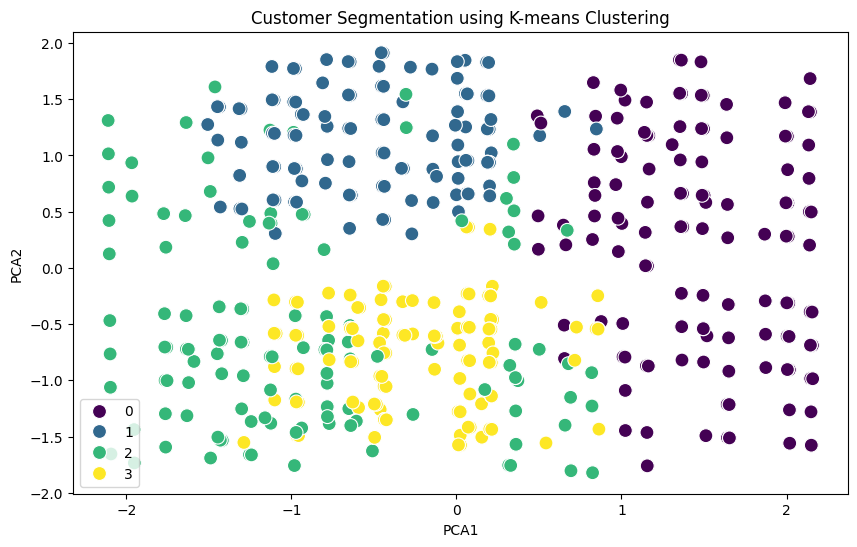

In [20]:
# Apply PCA to reduce the dimensions for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.drop('Cluster', axis=1))

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster']

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='viridis', s=100)
plt.title('Customer Segmentation using K-means Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


# Reducing the Predicted Churn Rate
## Step 1: Identify Customers Likely to Churn

In [21]:
# Predict churn probabilities for all customers in the dataset
df['Churn_Probability'] = best_pipeline.predict_proba(X)[:, 1]

# Identify customers likely to churn (e.g., probability > 0.5)
churn_customers = df[df['Churn_Probability'] > 0.5]

# Display the customers likely to churn
print(churn_customers)


          Age  FrequentFlyer  AnnualIncomeClass  ServicesOpted  \
1    0.566904              2                  1       1.596429   
5   -1.531645              2                  0      -0.895175   
7    0.566904              0                  1      -0.272274   
9    1.166489              2                  0      -0.895175   
11  -1.231853              0                  2      -0.272274   
..        ...            ...                ...            ...   
929 -1.231853              2                  0      -0.895175   
933 -0.632267              2                  0      -0.895175   
937 -0.632267              2                  1       1.596429   
945 -0.632267              2                  0       2.219330   
953 -0.332475              2                  0      -0.895175   

     AccountSyncedToSocialMedia  BookedHotelOrNot  Target  Cluster  \
1                             1                 0       1        2   
5                             0                 1       1        0 

## Step 2: Analyze Characteristics of Churn Customers

              Age  FrequentFlyer  AnnualIncomeClass  ServicesOpted  \
count  265.000000     265.000000         265.000000     265.000000   
mean    -0.203507       1.445283           0.633962      -0.032516   
std      1.038342       0.877878           0.661422       1.076673   
min     -1.531645       0.000000           0.000000      -0.895175   
25%     -1.231853       0.000000           0.000000      -0.895175   
50%     -0.632267       2.000000           1.000000      -0.272274   
75%      0.566904       2.000000           1.000000       0.973528   
max      1.766075       2.000000           2.000000       2.219330   

       AccountSyncedToSocialMedia  BookedHotelOrNot      Target     Cluster  \
count                  265.000000        265.000000  265.000000  265.000000   
mean                     0.445283          0.181132    0.777358    0.916981   
std                      0.497937          0.385856    0.416807    1.187328   
min                      0.000000          0.000000  

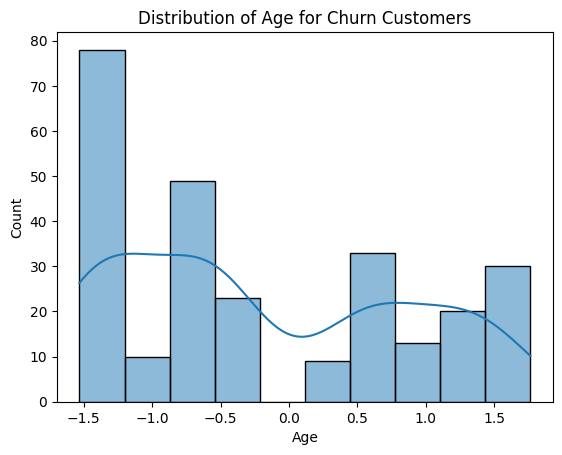

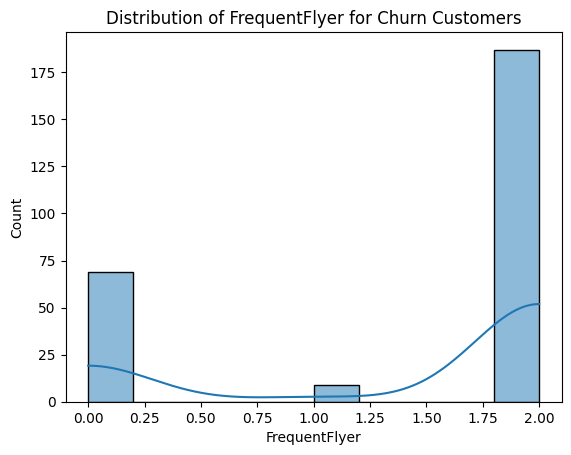

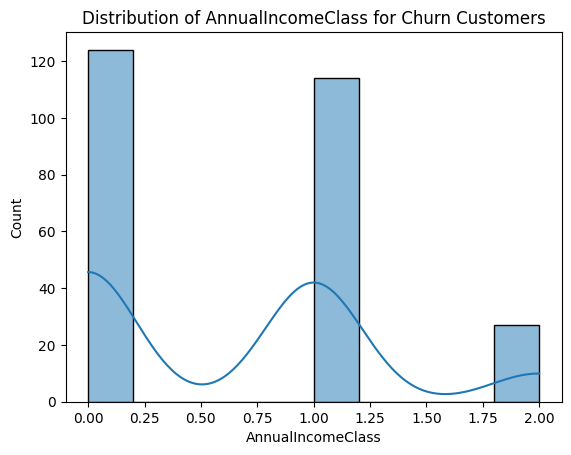

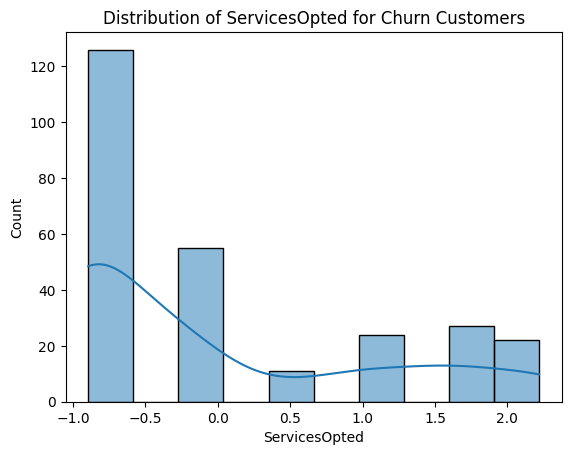

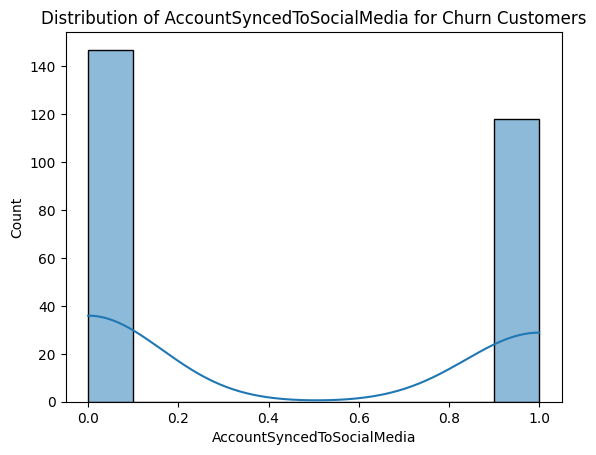

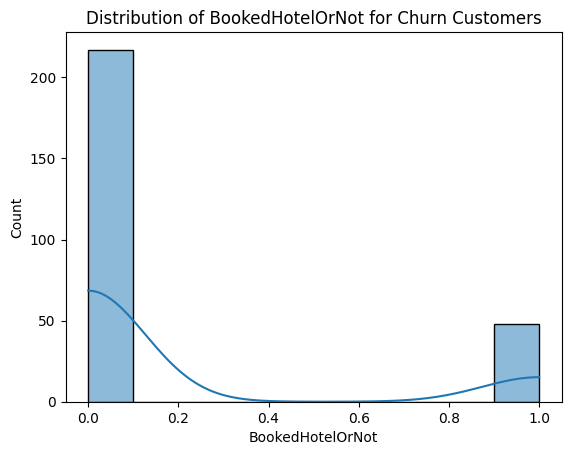

In [22]:
# Analyze the features of customers likely to churn
churn_features = churn_customers.describe()
print(churn_features)

# Visualize important features for churn customers
important_features = ['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot']
for feature in important_features:
    sns.histplot(churn_customers[feature], kde=True)
    plt.title(f'Distribution of {feature} for Churn Customers')
    plt.show()


## Step 3: Develop Targeted Retention Strategies

<ipython-input-23-7f82a01a3a48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['Retention_Offer'] = np.random.choice(['Discount', 'Loyalty Program', 'Improved Service'], size=len(customers))
<ipython-input-23-7f82a01a3a48>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['Retained'] = np.random.choice([1, 0], size=len(customers), p=[0.6, 0.4])


New Churn Rate after Implementing Retention Strategies: 11.74%
Effectiveness of Retention Offers:
Retention_Offer
Discount            0.652174
Improved Service    0.470588
Loyalty Program     0.638298
Name: Retained, dtype: float64


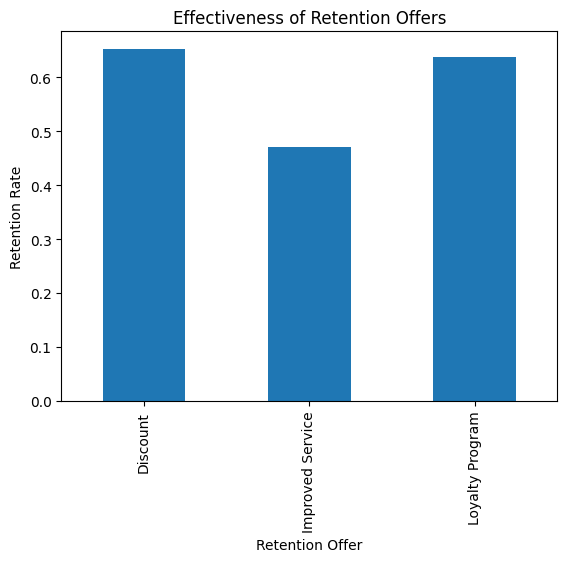

In [23]:
def implement_retention_strategies(customers):
    # Simulate retention strategies
    customers['Retention_Offer'] = np.random.choice(['Discount', 'Loyalty Program', 'Improved Service'], size=len(customers))
    # Assume a certain percentage of customers respond positively to the offers
    customers['Retained'] = np.random.choice([1, 0], size=len(customers), p=[0.6, 0.4])
    return customers

# Apply retention strategies to churn customers
retained_customers = implement_retention_strategies(churn_customers)

# Calculate the new churn rate after implementing retention strategies
new_churn_rate = (len(churn_customers) - retained_customers['Retained'].sum()) / len(df) * 100

# Print the new churn rate
print(f"New Churn Rate after Implementing Retention Strategies: {new_churn_rate:.2f}%")

# Analyze the effectiveness of different retention offers
offer_effectiveness = retained_customers.groupby('Retention_Offer')['Retained'].mean()
print("Effectiveness of Retention Offers:")
print(offer_effectiveness)

# Visualize the effectiveness of different retention offers
offer_effectiveness.plot(kind='bar')
plt.title('Effectiveness of Retention Offers')
plt.xlabel('Retention Offer')
plt.ylabel('Retention Rate')
plt.show()
